In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [21]:
#Habilitando compatibilidad con tensorflow v1
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Enabled compatitility to tf1.x


## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

In [4]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

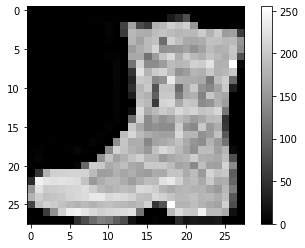

In [5]:
plt.imshow(train_images[150], cmap = 'gray')
plt.colorbar()

## Labels

In [6]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

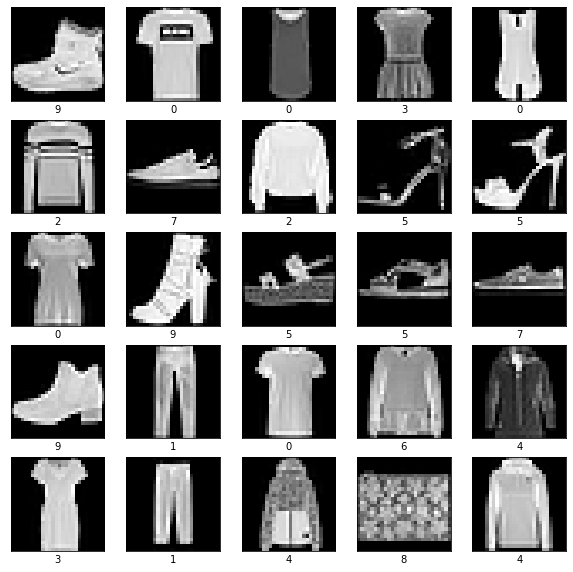

In [7]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

## Filtrado de clases


In [8]:
def filtrarClases(features,labels,clases):
    filtro = (labels == clases[0]) | (labels == clases[1]) | (labels == clases[2])
    labelsTrain = labels[filtro]
    labelsTrain[labelsTrain == clases[0]]=0
    labelsTrain[labelsTrain == clases[1]]=1
    labelsTrain[labelsTrain == clases[2]]=2
    return features[filtro],labelsTrain


In [9]:
filtroClases = np.array([0,3,7])

train_images_f,train_labels_f = filtrarClases(train_images,train_labels,filtroClases)
test_images_f,test_labels_f = filtrarClases(test_images,test_labels,filtroClases)
 

print(np.shape(train_images_f))
print(np.shape(train_labels_f))
print(np.shape(test_images_f))
print(np.shape(test_labels_f))

(18000, 28, 28)
(18000,)
(3000, 28, 28)
(3000,)


#### Función para unificar la matriz que representa a cada imagen en un solo vector de tamaño ancho*alto (28x28=784)

In [10]:
def unificarImagenes(matriz_imagenes):
    return np.reshape(matriz_imagenes, (matriz_imagenes.shape[0], matriz_imagenes.shape[1]*matriz_imagenes.shape[2]))

In [11]:
train_images_u = unificarImagenes(train_images_f)
test_images_u = unificarImagenes(test_images_f)
print(np.shape(train_images_u))
print(np.shape(test_images_u))

(18000, 784)
(3000, 784)


In [12]:
train_images_u = np.column_stack((np.ones(train_images_u.shape[0]), train_images_u))
test_images_u = np.column_stack((np.ones(test_images_u.shape[0]), test_images_u))
print(np.shape(train_images_u))
print(np.shape(test_images_u))
fil, col = train_images_u.shape

(18000, 785)
(3000, 785)


### Creando diccionario para los labels

In [13]:
labels_dict = {0:'T-shirt/top', 1:'Dress', 2:'Sneaker'}
print (labels_dict)

{0: 'T-shirt/top', 1: 'Dress', 2: 'Sneaker'}


## Definición del Grafo

In [14]:
tf.reset_default_graph()
g = tf.Graph()

with g.as_default(): 
    
    #Placeholder
    lr = tf.placeholder(tf.float32,name="lr")
    x  = tf.placeholder(tf.float32,shape=(None,col),name="x")
    y  = tf.placeholder(tf.int32, name = "y")

    #Variables
    with tf.name_scope("parametros"):
        w = tf.Variable(tf.truncated_normal(shape = [col, 3]), name = "w")

    #Calculando logits y estimaciones
    with tf.name_scope("Logits"):
        logits = tf.matmul(x, w, name = "logits") 
        yHat = tf.nn.softmax(logits, name = "YHat")

    #Definiendo función de costo    
    with tf.name_scope("Costo"):
        costo = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = logits), name = "Costo")

    # Optimizador de gradiente 
#   with tf.name_scope("OptimizadorGradiente"):
#   gradienteOptimizado = tf.train.GradientDescentOptimizer(lr).minimize(costo) 
        
    #Autodiferenciación para calcular gradiente
    with tf.name_scope("Gradiente"):
        grad = tf.gradients(costo,w)
        
    #Descenso de gradiente    
    with tf.name_scope("actualizado_parametros"):
        new_params = tf.assign(w, w - lr*grad[0] )

    #Calculando exactitud
    with tf.name_scope("Exactitud"):
        correctos = tf.equal(y, tf.argmax(yHat, 1, output_type = tf.int32), name = "correctos")
        exactitud = tf.reduce_mean(tf.cast(correctos, tf.float32), name = "exactitud")
        
    #Calculando métricas   
    with tf.name_scope("Metricas"):
        M_costo = tf.summary.scalar(name='costo', tensor = costo)
        M_exactitud = tf.summary.scalar(name='exactitud', tensor = exactitud)
        metricas = tf.summary.merge_all()
    
    # Inicializar variables globales
    init = tf.global_variables_initializer()


**Función para definir y entrenar el modelo**

In [15]:
def entrenar_modelo_regresion_logistica(x_vector,y_vector,epochs,imprimir_error_cada,learning_rate,batch_size,tipo):
    # Iniciando grafo
    with tf.Session(graph = g) as session:
        # Inicializamos las variables en la sesión
        session.run(init) 
        # Manejo de los logs en tensorboard
        writer = tf.summary.FileWriter('./tensorBoardLogs/'+ datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
                                       + '_GadientDescent_lr=' + str(learning_rate)
                                       + '_epochs=' + str(epochs)
                                       + '_tipo=' + str(tipo), session.graph)


        tamaño_muestra=x_vector.shape[0] 
        total_iteraciones = int(tamaño_muestra/batch_size)

        count=0    
        for epoch in range(epochs):
            for i in range(total_iteraciones):
                count=count+1
                muestra_inicio = i*batch_size
                muestra_fin = muestra_inicio + batch_size

                x_mb = np.array(x_vector[muestra_inicio:muestra_fin])
                y_mb = np.array(y_vector[muestra_inicio:muestra_fin])
                feed_dict = {x:x_mb, y:y_mb, lr:learning_rate}

#                 _, metrics = session.run([gradienteOptimizado, metricas], feed_dict = feed_dict)
                _, metrics = session.run([new_params, metricas], feed_dict = feed_dict)
                writer.add_summary(metrics, count)

                if ((i + 1) % imprimir_error_cada == 0): 
                    cost = session.run(costo, feed_dict = feed_dict)
                    print("Epoch = %d,\tIteración = %d,\tCosto: %0.4f" % (epoch+1, i+1, cost))
        writer.close()
        params = session.run(w)

    return params

In [16]:
mod1=entrenar_modelo_regresion_logistica(train_images_u/255,train_labels_f,2,250,0.0010,32,"SinNormalizar")
mod2=entrenar_modelo_regresion_logistica(train_images_u/255,train_labels_f,2,250,0.0025,32,"SinNormalizar")
mod3=entrenar_modelo_regresion_logistica(train_images_u/255,train_labels_f,2,250,0.0085,32,"SinNormalizar")
mod4=entrenar_modelo_regresion_logistica(train_images_u/255,train_labels_f,2,250,0.0400,32,"SinNormalizar")

Epoch = 1,	Iteración = 250,	Costo: 5.6849
Epoch = 1,	Iteración = 500,	Costo: 4.0003
Epoch = 2,	Iteración = 250,	Costo: 0.7106
Epoch = 2,	Iteración = 500,	Costo: 1.1520
Epoch = 1,	Iteración = 250,	Costo: 2.1342
Epoch = 1,	Iteración = 500,	Costo: 0.8231
Epoch = 2,	Iteración = 250,	Costo: 0.7687
Epoch = 2,	Iteración = 500,	Costo: 0.5874
Epoch = 1,	Iteración = 250,	Costo: 1.3559
Epoch = 1,	Iteración = 500,	Costo: 0.2342
Epoch = 2,	Iteración = 250,	Costo: 0.3997
Epoch = 2,	Iteración = 500,	Costo: 0.1283
Epoch = 1,	Iteración = 250,	Costo: 0.1684
Epoch = 1,	Iteración = 500,	Costo: 0.1407
Epoch = 2,	Iteración = 250,	Costo: 0.0608
Epoch = 2,	Iteración = 500,	Costo: 0.0989


In [17]:
mod5=entrenar_modelo_regresion_logistica(train_images_u/255,train_labels_f,2,250,0.0010,32,"Normalizado")
mod6=entrenar_modelo_regresion_logistica(train_images_u/255,train_labels_f,2,250,0.0025,32,"Normalizado")
mod7=entrenar_modelo_regresion_logistica(train_images_u/255,train_labels_f,2,250,0.0085,32,"Normalizado")
mod8=entrenar_modelo_regresion_logistica(train_images_u/255,train_labels_f,2,250,0.0400,32,"Normalizado")

Epoch = 1,	Iteración = 250,	Costo: 3.2798
Epoch = 1,	Iteración = 500,	Costo: 2.0350
Epoch = 2,	Iteración = 250,	Costo: 1.2415
Epoch = 2,	Iteración = 500,	Costo: 1.4517
Epoch = 1,	Iteración = 250,	Costo: 1.9927
Epoch = 1,	Iteración = 500,	Costo: 0.9837
Epoch = 2,	Iteración = 250,	Costo: 0.6328
Epoch = 2,	Iteración = 500,	Costo: 0.4470
Epoch = 1,	Iteración = 250,	Costo: 0.6391
Epoch = 1,	Iteración = 500,	Costo: 0.0635
Epoch = 2,	Iteración = 250,	Costo: 0.3467
Epoch = 2,	Iteración = 500,	Costo: 0.0502
Epoch = 1,	Iteración = 250,	Costo: 0.1788
Epoch = 1,	Iteración = 500,	Costo: 0.4817
Epoch = 2,	Iteración = 250,	Costo: 0.1023
Epoch = 2,	Iteración = 500,	Costo: 0.4028


### Grafo, costo y exactitud en Tensorboard

<img src="TensorBoard.png">

<img src="Metricas.png">

## Predecir clase

In [18]:
def predecirClase(x, w):
    return labels_dict[np.argmax(np.matmul(x, w))]

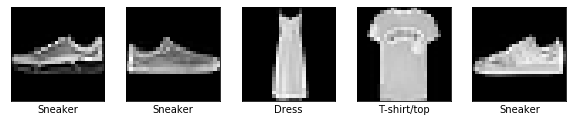

In [20]:
plt.figure(figsize=(10,10))

for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images_f[i], cmap='gray')
    plt.xlabel(predecirClase(test_images_u[i],mod8))     
plt.show()

## Conclusiones
Se puede observar que al comparar diversos modelos entrenados con distintos hiperparámetros de learning rate y con datos sin normalizar y normalizados el que mejor converge es el modelo que tiene las siguiente características:

* Entrenado con learning rate=0.04
* Con datos normalizados
* La exactitud del modelo en la última iteración es: 0.9035